In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
df = pd.read_csv('nn_dataset.csv')
print(f'loaded {len(df)} items')

loaded 4105 items


In [3]:
from sklearn.model_selection import train_test_split

THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]
limited_data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    # *(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
X_all, y_all = df[limited_data_columns], df['Meter']
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=4, stratify=y_all
)

# train_set, test_set = torch.utils.data.random_split(all_data, [.8, .2], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(X_train)}, validation examples = {len(X_test)}")
print(X_train.shape)
print(4103 in X_train.index, 4100 in X_train.index)

train examples = 3284, validation examples = 821
(3284, 17)
True True


In [4]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [35]:
param = {
    #device='cuda',
    'max_depth': 2,
    'eta': 0.1,
    'lambda': 2,
    'objective': 'reg:squarederror'
}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_boost_round=5000, evals=watchlist)
# cuda: 32.5s
# cpu: 14.1s

[0]	eval-rmse:8.54290	train-rmse:8.51983
[1]	eval-rmse:7.80653	train-rmse:7.78473
[2]	eval-rmse:7.13095	train-rmse:7.11087
[3]	eval-rmse:6.53065	train-rmse:6.51301
[4]	eval-rmse:5.98581	train-rmse:5.96841
[5]	eval-rmse:5.49044	train-rmse:5.46923
[6]	eval-rmse:5.05321	train-rmse:5.02822
[7]	eval-rmse:4.65563	train-rmse:4.62948
[8]	eval-rmse:4.30109	train-rmse:4.27151
[9]	eval-rmse:3.96959	train-rmse:3.94821
[10]	eval-rmse:3.67796	train-rmse:3.65676
[11]	eval-rmse:3.41794	train-rmse:3.39829
[12]	eval-rmse:3.17231	train-rmse:3.15710
[13]	eval-rmse:2.96413	train-rmse:2.94627
[14]	eval-rmse:2.76194	train-rmse:2.75211
[15]	eval-rmse:2.58991	train-rmse:2.58139
[16]	eval-rmse:2.43992	train-rmse:2.43125
[17]	eval-rmse:2.29461	train-rmse:2.28678
[18]	eval-rmse:2.17126	train-rmse:2.16318
[19]	eval-rmse:2.06079	train-rmse:2.05534
[20]	eval-rmse:1.95616	train-rmse:1.95508
[21]	eval-rmse:1.87226	train-rmse:1.86701
[22]	eval-rmse:1.79236	train-rmse:1.78813
[23]	eval-rmse:1.72183	train-rmse:1.71604
[2

In [36]:
preds = bst.predict(dtest)
labels = dtest.get_label()
print(
    "accuracy=%f"
    % (
        sum(1 for i in range(len(preds)) if round(preds[i]) == labels[i])
        / float(len(preds))
    )
)

accuracy=0.679659


In [93]:
from sklearn.model_selection import GridSearchCV, KFold

model = xgb.XGBRegressor(
    n_estimators=2000, max_depth=6,
    alpha=1, reg_lambda=1,
    learning_rate=0.1,
    early_stopping_rounds=30
)

# param_grid = {
#     'reg_lambda': [0, 0.1, 0.5, 1, 5, 10, 50, 100],
#     'alpha': [0, 0.1, 1, 10, 100]
# }
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)
# # Get results
# print(f"Best params: {grid_search.best_params_}")
# print(f"Best CV MSE: {-grid_search.best_score_:.4f}")

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])


[0]	validation_0-rmse:8.43394	validation_1-rmse:8.46275
[1]	validation_0-rmse:7.61317	validation_1-rmse:7.64533
[2]	validation_0-rmse:6.87399	validation_1-rmse:6.90760
[3]	validation_0-rmse:6.20820	validation_1-rmse:6.24382
[4]	validation_0-rmse:5.60926	validation_1-rmse:5.64636
[5]	validation_0-rmse:5.06876	validation_1-rmse:5.10932
[6]	validation_0-rmse:4.58194	validation_1-rmse:4.62569
[7]	validation_0-rmse:4.14439	validation_1-rmse:4.18984
[8]	validation_0-rmse:3.74960	validation_1-rmse:3.79894
[9]	validation_0-rmse:3.39445	validation_1-rmse:3.44662
[10]	validation_0-rmse:3.07516	validation_1-rmse:3.13022
[11]	validation_0-rmse:2.78770	validation_1-rmse:2.84545
[12]	validation_0-rmse:2.52894	validation_1-rmse:2.58877
[13]	validation_0-rmse:2.29629	validation_1-rmse:2.35754
[14]	validation_0-rmse:2.08647	validation_1-rmse:2.15118
[15]	validation_0-rmse:1.89849	validation_1-rmse:1.96704
[16]	validation_0-rmse:1.72939	validation_1-rmse:1.80117
[17]	validation_0-rmse:1.57746	validation

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,30
,enable_categorical,False
,eval_metric,None


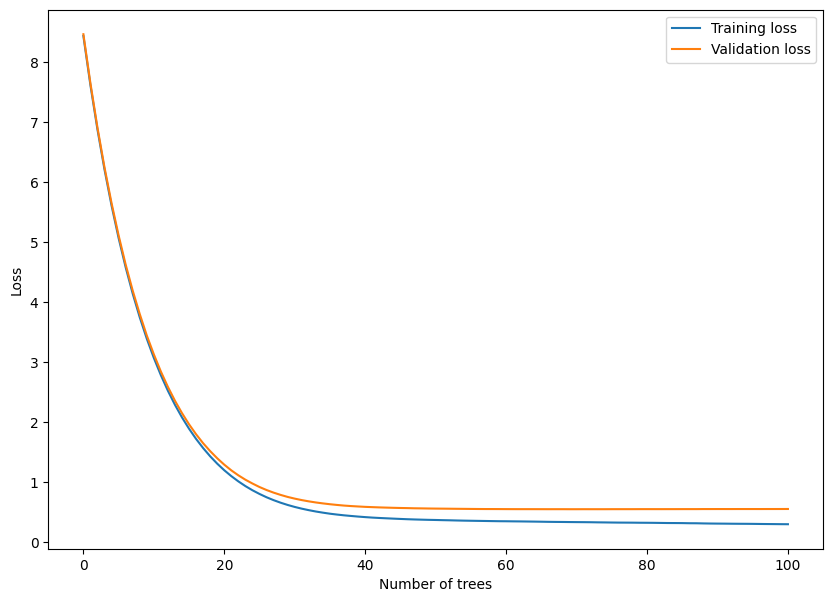

In [53]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [94]:
y_pred = model.predict(X_test)
(np.round(y_pred) == y_test).sum() / len(y_test) * 100

np.float64(70.28014616321559)

In [19]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh import palettes

output_notebook()

Loading BokehJS ...

In [95]:
from bokeh.models.tickers import BasicTicker
def bokeh_display(X_test, y_test, names_df=None, palette=palettes.Turbo256):
    if names_df is None:
        names_df = df

    # preds = bst.predict(dtest)
    preds = model.predict(X_test)

    disp_df = pd.DataFrame(index=y_test.index)
    disp_df['y'] = preds
    disp_df['x'] = y_test
    disp_df = disp_df.merge(names_df[['Name', 'Meter']], left_index=True, right_index=True)

    datasource = ColumnDataSource(disp_df)
    color_mapping = LinearColorMapper(
        palette=palette
    )

    plot_figure = figure(
        width=500,
        height=500,
        tools=('pan, wheel_zoom, reset')
    )

    hvr = HoverTool(tooltips="""
    <div>
        <div>
            <span style='font-size: 12px; color: #224499'>[@Meter]</span>
            <span style='font-size: 12px; color: #994422'>[@y]</span>
            <span style='font-size: 12px'>@Name</span>
        </div>
    </div>
    """)
    plot_figure.add_tools(hvr)

    scatter = plot_figure.scatter(
        'x',
        'y',
        source=datasource,
        color=dict(field='Meter', transform=color_mapping),
        line_alpha=0,
        fill_alpha=0.5,
        size=8
    )
    hvr.renderers = [scatter]
    line_vals = np.arange(min(y_test), max(y_test)+1)
    plot_figure.line(x=line_vals, y=line_vals)
    plot_figure.ygrid.ticker = BasicTicker(min_interval=1, max_interval=1)
    show(plot_figure)

bokeh_display(X_test, y_test, palette=palettes.Turbo256*2)

In [28]:
import math
from fractions import Fraction

def get_block_repr(bpm, measures):
    THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
    BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]

    nps = bpm * 4 / 60
    measure_len = 60 / bpm * 4
    max_nps = math.ceil(nps)
    max_nps_lower = max_nps - 1
    length_secs = measure_len * measures
    length = length_secs * 2

    prop_higher = nps % 1 if nps < max_nps else 1
    prop_lower = 1 - prop_higher
    lower_bin_i = -1
    for thresh in THRESHOLDS:
        if max_nps_lower > thresh * max_nps:
            lower_bin_i += 1
        else:
            break
    
    avg_nps_per_bin = [(t+0.1) * max_nps for t in THRESHOLDS]
    nps_vals_are_in_same_bin = lower_bin_i == len(THRESHOLDS) - 1 or nps == max_nps
    if nps_vals_are_in_same_bin:
        avg_nps_per_bin[-1] = nps
    else:
        avg_nps_per_bin[-1] = max_nps
        if lower_bin_i > -1:
            avg_nps_per_bin[lower_bin_i] = max_nps_lower
    
    threshold_counts = [length for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        for i in range(lower_bin_i+1, len(THRESHOLDS)):
            threshold_counts[i] = length * prop_higher
    
    density_per_bin = [1 for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        for i in range(lower_bin_i+1, len(THRESHOLDS)):
            threshold_counts[i] = prop_higher    

    # longest continuous block of NPS >= threshold
    # allowing for different lengths of break
    longest_blocks = [[length for _ in BREAK_LENGTHS] for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        #print(nps, lower_bin_i, prop_higher, prop_lower)
        ratio_higher_to_lower = prop_higher / prop_lower
        if ratio_higher_to_lower > 1:
            block_len = math.ceil(ratio_higher_to_lower)
            break_len = 1
        else:
            block_len = 1
            break_len = math.ceil(1 / ratio_higher_to_lower)
        for thresh_i in range(lower_bin_i+1, len(THRESHOLDS)):
            for break_i, max_break_len in enumerate(BREAK_LENGTHS):
                if break_len > max_break_len:
                    longest_blocks[thresh_i][break_i] = block_len

    return [
        max_nps,
        math.log2(length+1),
        # avg_nps_per_bin,
        # threshold_counts,
        # density_per_bin,
        # longest_blocks
        *avg_nps_per_bin,
        *(math.log2(x+1) for x in threshold_counts),
        *density_per_bin
        #*(math.log2(x+1) for row in longest_blocks for x in row)
    ]

In [97]:
RESOLUTION = 200
STREAM_BOUNDS = (0, 16)
BPM_BOUNDS = (10, 600)
x, y = np.meshgrid(
    np.linspace(BPM_BOUNDS[0], BPM_BOUNDS[1], RESOLUTION),
    np.linspace(STREAM_BOUNDS[0], STREAM_BOUNDS[1], RESOLUTION)
)
inp = np.reshape(np.dstack((x, y)), (-1, 2))
inp = [get_block_repr(item[0], 2**item[1]) for item in inp]
#image = bst.predict(xgb.DMatrix(pd.DataFrame(inp, columns=limited_data_columns)))
image = model.predict(inp)
image = image.reshape((RESOLUTION, RESOLUTION))

1.8047932 42.49943


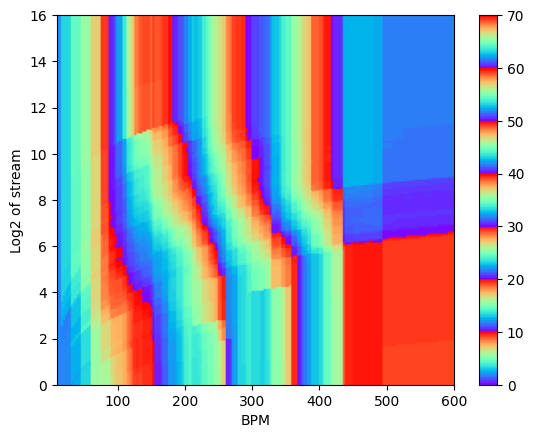

In [98]:
import matplotlib
from matplotlib.colors import ListedColormap, Normalize

vmin = np.min(image)
vmax = np.max(image)
print(vmin, vmax)
norm = Normalize(vmin=vmin-0.5, vmax=vmax+0.5)
norm = Normalize(vmin=0, vmax=70)
cmap = matplotlib.colormaps['rainbow']
cmap = ListedColormap(cmap(np.linspace(0, 7, int(500)) % 1))
# cmap = matplotlib.colormaps['viridis']

fig = plt.figure()
ax = fig.add_subplot()

#ax.view_init(elev=90, azim=-90, roll=0)
ax.set_xlabel('BPM')
ax.set_ylabel('Log2 of stream')
#ax.set_zlabel('Density')
pos = ax.imshow(image, origin='lower', cmap=cmap, alpha=1, extent=(*BPM_BOUNDS, *STREAM_BOUNDS),
          aspect='auto', norm=norm)
fig.colorbar(pos)
plt.show()

In [85]:
from analysis.analyzer import SongAnalyzer
from analysis.hash import get_hash
import math
import itertools
import simfile

THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]
def extract_features(seq: list[int]):
    max_nps = max(seq)
    length = len(seq)
    cum_nps_per_bin = [0 for _ in THRESHOLDS]
    count_per_bin = [0 for _ in THRESHOLDS]
    # num of samples where NPS > the threshold (fraction of max NPS)
    threshold_counts = [0 for _ in THRESHOLDS]
    segs_per_thresh = [[] for _ in THRESHOLDS]
    for nps in seq:
        for thresh_i, thresh in enumerate(THRESHOLDS):
            segs = segs_per_thresh[thresh_i]
            if nps > thresh * max_nps:
                threshold_counts[thresh_i] += 1
                if not segs or segs[-1] < 0: # if prev was break, start a new seg
                    segs.append(0)
                segs[-1] += 1
            else:
                if not segs or segs[-1] > 0: # if prev was a block, start a new seg
                    segs.append(0)
                segs[-1] -= 1
        bin_i = -1
        for thresh in THRESHOLDS:
            if nps > thresh * max_nps:
                bin_i += 1
            else:
                break
        if bin_i > -1:
            cum_nps_per_bin[bin_i] += nps
            count_per_bin[bin_i] += 1
    
    default_avg_nps = [x * max_nps for x in (0.1, 0.3, 0.5, 0.7, 0.9)]
    avg_nps_per_bin = [
        (cum_nps / count if count > 0 else default)
        for cum_nps, count, default in zip(cum_nps_per_bin, count_per_bin, default_avg_nps)
    ]

    density_per_bin = []
    for segs, count in zip(segs_per_thresh, threshold_counts):
        total_len = length
        if segs:
            if segs[0] < 0:
                total_len += segs[0]
            if len(segs) > 1 and segs[-1] < 0:
                total_len += segs[-1]
            density_per_bin.append(count / total_len)
        else:
            density_per_bin.append(0)

    return [
        max_nps,
        math.log2(length+1),
        # avg_nps_per_bin,
        # threshold_counts,
        # density_per_bin
        # longest_blocks
        *avg_nps_per_bin,
        *(math.log2(x+1) for x in threshold_counts),
        *density_per_bin
    ]

data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    # *(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
columns = [
    'Name', 'Hash', 'Meter',
    *data_columns
]

def handle_song(song, pack_name, seen_hashes):
    data = []
    song_analyzer = SongAnalyzer(song)
    song_str = f'{pack_name}/{song.title or ""}'

    for chart_analyzer in song_analyzer.chart_analyzers.values():
        chart = chart_analyzer.chart
        if (chart.stepstype or '').lower() != 'dance-single':
            continue
        diff = (chart.difficulty or '').lower()
        title = song_str
        if diff != 'challenge':
            title += f' ({diff})'

        chart_hash = get_hash(song, chart_analyzer.chart)
        if chart_hash in seen_hashes:
            print(f'skipping {title} (dupe hash)')
            continue
        seen_hashes.add(chart_hash)
        print(f'analyzing {title}')
        try:
            meter = int(chart_analyzer.chart.meter)
        except ValueError:
            print(song.title, ': invalid meter')
            continue

        seq1 = chart_analyzer.get_notes_per_second_list(-0.5)
        seq2 = chart_analyzer.get_notes_per_second_list(0)
        seq = [
            val for pair in itertools.zip_longest(seq1, seq2, fillvalue=0)
            for val in pair
        ]

        try:
            start = next(i for i,v in enumerate(seq) if v > 0)
            end = next(i for i,v in enumerate(reversed(seq)) if v > 0)
        except StopIteration:
            print(title, ': empty?')
            continue

        seq = seq[start:len(seq)-end]
        # print(seq)
        features = extract_features(seq)
        # print(features)

        data.append((
            title,
            chart_hash,
            meter,
            *features
        ))
    return data

c:\Users\Lenovo\Documents\code_projs\itg-difficulty-predictor\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [89]:
from simfile.dir import SimfilePack

pack_path = r"C:\Users\Lenovo\AppData\Roaming\ITGmania\Songs\Cametech"
real_test_data = []
seen_hashes = set()
pack = SimfilePack(pack_path)
for song in pack.simfiles(strict=False):
     real_test_data.extend(handle_song(song, pack.name, seen_hashes))

# song = simfile.open(r'pack_archive\651b1724-688f-4197-9cb6-7206f80f0dc2_24_hours_of_100_bpm_stream.sm')
# real_test_data.extend(handle_song(song, pack.name, seen_hashes))

test_df = pd.DataFrame(real_test_data, columns=columns)
X_real, y_real = test_df[limited_data_columns], test_df['Meter']

analyzing Cametech/(The) Red * Room (hard)
analyzing Cametech/(The) Red * Room
analyzing Cametech/(The) Red * Room (medium)
analyzing Cametech/(The) Red * Room (easy)
analyzing Cametech/+ERABY+E CONNEC+10N
analyzing Cametech/+ERABY+E CONNEC+10N (hard)
analyzing Cametech/+ERABY+E CONNEC+10N (medium)
analyzing Cametech/+ERABY+E CONNEC+10N (easy)
analyzing Cametech/1nput This 2 Y0ur Spine
analyzing Cametech/1nput This 2 Y0ur Spine (hard)
analyzing Cametech/1nput This 2 Y0ur Spine (medium)
analyzing Cametech/1nput This 2 Y0ur Spine (easy)
analyzing Cametech/Another Xronixle
analyzing Cametech/Another Xronixle (hard)
analyzing Cametech/Another Xronixle (medium)
analyzing Cametech/Another Xronixle (easy)
analyzing Cametech/AREA 52
analyzing Cametech/AREA 52 (hard)
analyzing Cametech/AREA 52 (medium)
analyzing Cametech/AREA 52 (easy)
analyzing Cametech/Artificial Snow
analyzing Cametech/Artificial Snow (hard)
analyzing Cametech/Artificial Snow (medium)
analyzing Cametech/Artificial Snow (easy

In [96]:
bokeh_display(X_real, y_real, test_df)